In [ ]:
!nvidia-smi

In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import cv2

import tensorflow as tf
# 自動增長 GPU 記憶體用量
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 Session
tf.keras.backend.set_session(sess)


Using TensorFlow backend.


In [2]:
import os
img_base_path = '/home/z99792458/nbs/Dataset/img_defects/hci_defect_datasets/'
class1_path = os.path.join(img_base_path, 'Class4')
class1_train_path = os.path.join(class1_path, 'Train')
class1_test_path = os.path.join(class1_path, 'Test')
labeled_img = [x[:4] for x in os.listdir(os.path.join(class1_train_path, 'Label'))] + [x[:4] for x in os.listdir(os.path.join(class1_test_path, 'Label'))]
labeled_img = list(set(labeled_img))
all_img = [x for x in os.listdir(class1_train_path) if x.find('_256') >-1] + [x for x in os.listdir(class1_test_path) if x.find('_256') >-1]
normal_img_name = [x for x in all_img if x[:4] not in labeled_img]
defect_img_name = [x for x in all_img if x[:4] in labeled_img]
train_img_names, test_img_names = train_test_split(normal_img_name, test_size=0.25)

train_imgs = list()
test_imgs = list()
for img_name in os.listdir(class1_train_path):
    if (img_name in train_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            train_imgs.append(img)
    if (img_name in test_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            test_imgs.append(img)

for img_name in os.listdir(class1_test_path):
    if (img_name in train_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_test_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            train_imgs.append(img)
    if (img_name in test_img_names) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_test_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            test_imgs.append(img)

train_imgs = (np.stack(train_imgs)).astype(float)/255
test_imgs = (np.stack(test_imgs)).astype(float)/255

img_shape = train_imgs.shape[1:]
num_units = img_shape[0]*img_shape[1]*img_shape[2]

train_imgs = train_imgs.reshape(train_imgs.shape[0], num_units)
test_imgs = test_imgs.reshape(test_imgs.shape[0], num_units)

In [3]:
# Get defected images
defect_imgs = list()
for img_name in os.listdir(class1_train_path):
    if (img_name in defect_img_name) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            defect_imgs.append(img)
for img_name in os.listdir(class1_test_path):
    if (img_name in defect_img_name) and (img_name.find('_256') > -1) and (img_name.find('PNG') > -1):
        img = cv2.imread(os.path.join(class1_train_path, img_name), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = img.reshape(img.shape[0], img.shape[1], 1)
            defect_imgs.append(img)
defect_imgs = (np.stack(defect_imgs)).astype(float)/255
defect_imgs = defect_imgs.reshape(defect_imgs.shape[0], -1)

In [4]:
num_units 

65536

In [5]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [6]:
inputs = Input(shape=(num_units,))

x = inputs
encoded = Dense(units=int(num_units/4), activation='relu')(x)
encoded = Dense(units=int(num_units/16), activation='relu')(encoded)
decoded = Dense(units=int(num_units/4), activation='relu')(encoded)
decoded = Dense(units=int(num_units), activation='sigmoid')(decoded)
model = Model(inputs=inputs, outputs=decoded)
model.compile(loss='mse',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Learning rate:  0.001
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             1073758208
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              67112960  
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             67125248  
_________________________________________________________________
dense_4 (Dense)              (None, 65536)             1073807360
Total params: 2,281,803,776
Trainable params: 2,281,803,776
Non-trainable params: 0
_________________________________________________________________


In [7]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


In [8]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
import datetime as dt
model_name = 'deep_autoencoder_256_%s_{epoch:03d}.h5' % ( dt.datetime.now().strftime("%Y%m%d%H"))
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [10]:
callbacks = [lr_reducer, lr_scheduler]
# callbacks = []

In [11]:
# Run training
history = model.fit(train_imgs, train_imgs,
          batch_size=4,
          epochs=3000,
          validation_data=(test_imgs, test_imgs),
          shuffle=True,
          callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 750 samples, validate on 250 samples
Epoch 1/3000


ResourceExhaustedError: OOM when allocating tensor with shape[65536,16384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/Adam/Variable_8/Assign (defined at /home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:402) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/Adam/Variable_8/Assign', defined at:
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-1cfbdd43d976>", line 7, in <module>
    callbacks=callbacks)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/engine/training.py", line 1010, in fit
    self._make_train_function()
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/optimizers.py", line 488, in get_updates
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/optimizers.py", line 488, in <listcomp>
    vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 704, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1547, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 223, in assign
    validate_shape=validate_shape)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 64, in assign
    use_locking=use_locking, name=name)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[65536,16384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/Adam/Variable_8/Assign (defined at /home/z99792458/anaconda_env/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:402) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
model.save_weights("./saved_models/" + model_name + "_final_models.h5") 


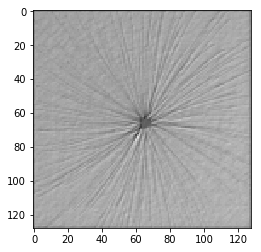

In [22]:
img = test_imgs[7]
plt.imshow(img.reshape((128, 128)), cmap=cm.gray, vmin=0.0, vmax=1.0)
predicted = model.predict(img.reshape(img.shape[0], 1).T)

predicted = predicted.reshape((128, 128))


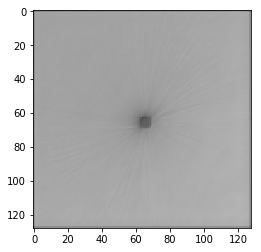

In [24]:
plt.imshow(predicted, cmap=cm.gray, vmin=0.0, vmax=1.0)

In [ ]:
img = test_imgs[2]
plt.imshow(img.reshape((256, 256)))
predicted = model.predict(img.reshape(img.shape[0], 1).T)

predicted = predicted.reshape((256,256))


In [ ]:
plt.imshow(predicted)